In [1]:
#!pip install girth
from girth import twopl_jml, ability_mle, ability_map
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import seed
from uuid import  uuid4
RANDOM_STATE =1
seed(RANDOM_STATE)

In [2]:
def irf(diff: float, disc: float, ability: float):
    """Item Response (Characteristic) Function
    
    Compute the probability that a subject with given ability will answer an item 
    with difficulty `diff` and discrimination `disc` correctly
    
    """
    #return 1/(1 + exp_part(diff,disc,ability))
    return 1/(1+ np.exp(-disc*(ability-diff)))

In [3]:
def construct_lsat7_dataset(path_to_csv: str = "/home/daavid/lsat7.csv") -> pd.DataFrame:
    lsat7 = pd.read_csv(path_to_csv)
    lsat7 = lsat7.drop(columns="Unnamed: 0")
    lsat7 = lsat7.rename(columns={col:col.replace(".","_") for col in lsat7.columns})
    lsat7.index.repeat(lsat7.freq)
    expanded = pd.DataFrame(np.repeat(lsat7.values, lsat7.freq, axis=0),columns=lsat7.columns).drop(columns="freq")
    return expanded
    

In [4]:
lsat7= construct_lsat7_dataset()

In [5]:
params = twopl_jml(lsat7.transpose())

In [6]:
params_df =pd.DataFrame(params)
params_df

,Discrimination,Difficulty
0,0.80286,-1.202129
1,4.00000,0.368345
2,4.00000,0.058751
3,0.25000,1.380074
4,0.25000,-4.902024


In [7]:
#this approach has nans
#abilities = ability_mle(dataset=lsat7.transpose().to_numpy(), difficulty = params["Difficulty"], discrimination=params["Discrimination"])


In [8]:
abilities = ability_map(dataset=lsat7.transpose().to_numpy(), difficulty = params["Difficulty"], discrimination=params["Discrimination"])


(array([ 32.,   7.,  91.,   0.,   0.,  87., 223.,   0.,  66., 494.]),
 array([-0.85908197, -0.68427015, -0.50945833, -0.3346465 , -0.15983468,
         0.01497714,  0.18978896,  0.36460078,  0.53941261,  0.71422443,
         0.88903625]),
 <BarContainer object of 10 artists>)

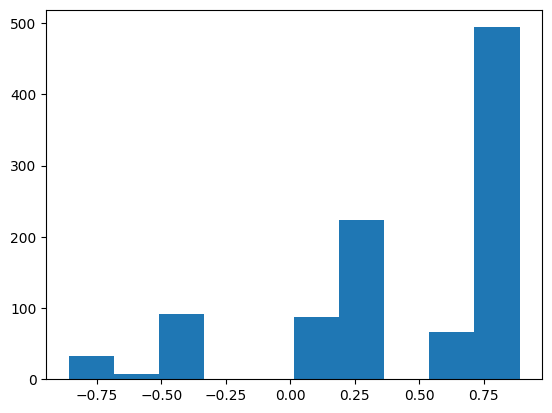

In [9]:

plt.hist(abilities)

In [10]:
predictions = list()
for ability in abilities:
    item_preds = list()
    for idx, (disc,diff) in params_df.iterrows():
        prob = irf(ability=ability, diff=diff, disc=disc)
        item_preds.append(round(prob))
    predictions.append(item_preds)
predictions

[[1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1],
 [1, 0, 1,

In [11]:
len(predictions)

1000

In [12]:
len(lsat7.to_numpy())

1000

__Accuracy__

In [13]:
np.sum(predictions == lsat7.to_numpy())/5000

0.7738

__Goal here is to get a plot of sample size vs. accuracy__

In [14]:
def fit_model(dataset):
    item_params = twopl_jml(dataset.transpose())
    abilities = ability_map(dataset=dataset.transpose().to_numpy(), difficulty = item_params["Difficulty"], discrimination=item_params["Discrimination"])
    return item_params, abilities
    
def predict(abilities, item_params):
    predictions = list()
    item_params_df = pd.DataFrame(item_params)
    for ability in abilities:
        item_preds = list()
        for idx, (disc,diff) in item_params_df.iterrows():
            prob = irf(ability=ability, diff=diff, disc=disc)
            item_preds.append(round(prob))
        predictions.append(item_preds)
    return predictions
    
def get_acc(y_pred,y_true):
    y_true = y_true.to_numpy()
    return np.sum(y_pred == y_true)/y_true.size
    


In [15]:
it, ab = fit_model(lsat7)

In [16]:
preds = predict(abilities, params)

In [17]:
get_acc(y_pred = preds, y_true =lsat7)

0.7738

In [18]:
np.linspace(100,1000,10)

array([ 100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900.,
       1000.])

In [19]:
accs = list()
ns = np.linspace(100,1000,10).astype(int)
for n in ns:
    sample = lsat7.sample(n=n,random_state=1)
    item_params, abilities = fit_model(sample)
    preds = predict(abilities, item_params)
    acc = get_acc(y_pred = preds, y_true =sample)
    accs.append(acc)
    
    

In [20]:
accs

[0.756,
 0.767,
 0.7746666666666666,
 0.765,
 0.768,
 0.771,
 0.7525714285714286,
 0.7715,
 0.7726666666666666,
 0.7738]

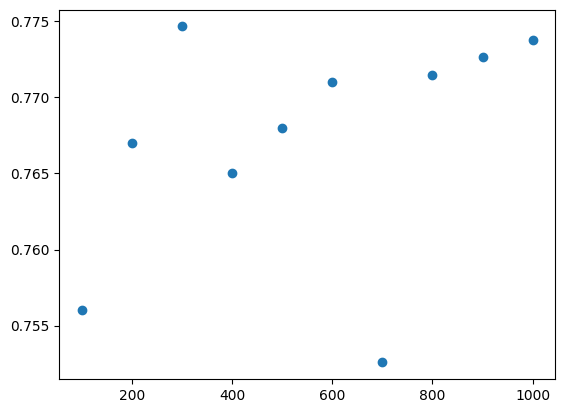

In [21]:
plt.scatter(np.linspace(100,1000,10).astype(int),accs)

n: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.35s/it]


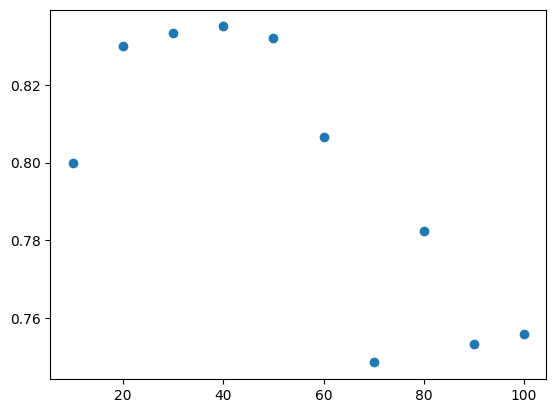

In [22]:
from tqdm import tqdm
accs = list()
ns = np.linspace(10,100,10).astype(int)
for n in tqdm(ns, "n"):
    n_acc = list()
    for i in tqdm(range(10)):
        sample = lsat7.sample(n=n,random_state=1)
        item_params, abilities = fit_model(sample)
        preds = predict(abilities, item_params)
        acc = get_acc(y_pred = preds, y_true =sample)
        n_acc.append(acc)
    acc = np.mean(n_acc)
    accs.append(acc)
    
plt.scatter(ns,accs)

This is training acuracy. I think this might have to do with the uneven response distribution. I wonder what it would look like with stratified sampling

In [23]:
#Let's try simulated data
N_ITEMS = 2000
N_SUBJECTS = 10_000
discriminations = np.random.gamma(size=N_ITEMS, shape=1, scale=2)
abilities = np.random.normal(size=N_SUBJECTS,loc=0,scale=1.01)
difficulties =   np.random.normal(size=N_ITEMS,loc=0,scale=1.01)
subjects = pd.DataFrame({"id": [str(uuid4()) for i in range(N_SUBJECTS) ], "ability": abilities})
items = pd.DataFrame({"id": [str(uuid4()) for i in range(N_ITEMS)], "difficulty": difficulties, "discrimination": discriminations })

<Axes: >

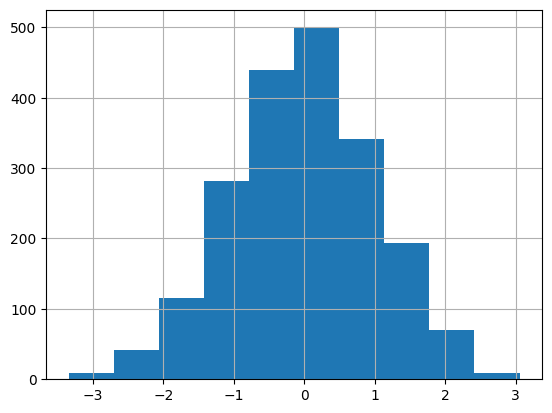

In [24]:
items.difficulty.hist()

<Axes: >

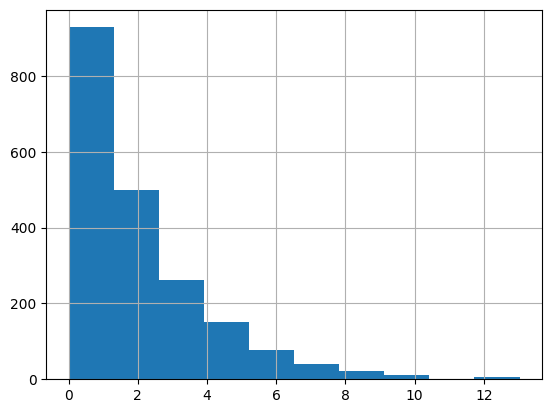

In [25]:
items.discrimination.hist()

In [26]:
items

,id,difficulty,discrimination
0,4b9b2abc-8ba3-4ce6-8f4a-995926d20edd,0.821853,1.079212
1,d6490ff1-7d5d-4cd1-b0e0-679df0b4eefa,0.865155,2.548251
2,b173ea34-fa7d-4465-9a46-922183d39776,0.530961,0.000229
3,b2ba438b-5bec-47dc-820a-f3af289f18f5,-0.127188,0.720026
4,3b099270-bd38-4b41-bccb-7294d6404784,1.211208,0.317419
...,...,...,...
1995,3a771311-f396-4ee0-b631-e2b3e32ebcc2,0.661567,1.186633
1996,918f0683-fe79-4724-9dd5-92918fe8e248,0.477096,0.406995
1997,a0e8f7a4-2cc7-4a36-b76a-1d9654bbedd9,1.877074,3.529061
1998,9f1affe6-f57e-46f5-9cf9-8b30bdc686ee,-1.374088,0.062977


I think we need to use synthetic data here. because what does test accuracy even mean here? in order to make predictions, we need ability, disc, and diff. but we can't get those params unless we fit hte model on those questions/students, and then they aren't unseen data anymore.

What you could consider as out of sample is *pairs* of students and questions that the model hasn't seen before. We've seen question A and student X but we haven't seen student X's response to question A.

(array([  13.,  145.,  717., 1944., 2899., 2586., 1251.,  379.,   57.,
           9.]),
 array([-3.6930045 , -2.9169923 , -2.14098009, -1.36496789, -0.58895569,
         0.18705652,  0.96306872,  1.73908092,  2.51509313,  3.29110533,
         4.06711753]),
 <BarContainer object of 10 artists>)

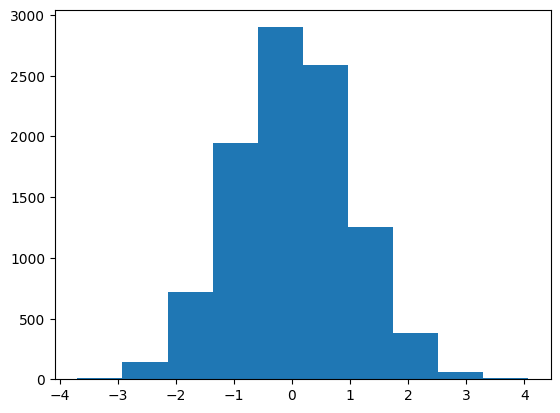

In [27]:
plt.hist(abilities)

In [28]:
len(abilities)

10000

In [29]:
test_subjects = subjects.sample(frac=0.1, random_state=RANDOM_STATE)
train_subjects = subjects.iloc[subjects.index.difference(test_subjects.index)]

In [30]:
len(test_subjects)

1000

In [31]:
len(train_subjects)

9000

we need to generate some synthetic responses based on these abilities and discriminations

In [32]:
#for each student, produce a dataframe of responses for each question. then just cat them all together.

__TODO__ save this as a csv or something so that the presentation attendees don't have to run it, as it takes a couple minutes

In [33]:
responses_by_subject = list()
for row_id, columns in tqdm(subjects.iterrows(), "rows"):
    subject_id = columns.id
    ability = columns.ability
    subject_resp = items.copy().rename(columns={"id":"item_id"}).drop(columns=["difficulty", "discrimination"])
    subject_resp["subject_id"] = subject_id
    subject_resp["correct"] = pd.DataFrame(items.apply(lambda item: np.random.binomial(n=1,p=irf(diff=item["difficulty"],disc=item["discrimination"],ability=ability)),axis=1))
    responses_by_subject.append(subject_resp)
responses_by_subject = pd.concat(responses_by_subject)
responses_by_subject

rows: 10000it [03:40, 45.44it/s]


,item_id,subject_id,correct
0,4b9b2abc-8ba3-4ce6-8f4a-995926d20edd,37c808f3-16de-4afe-8eb8-3c1a174c5fe0,0
1,d6490ff1-7d5d-4cd1-b0e0-679df0b4eefa,37c808f3-16de-4afe-8eb8-3c1a174c5fe0,0
2,b173ea34-fa7d-4465-9a46-922183d39776,37c808f3-16de-4afe-8eb8-3c1a174c5fe0,1
3,b2ba438b-5bec-47dc-820a-f3af289f18f5,37c808f3-16de-4afe-8eb8-3c1a174c5fe0,0
4,3b099270-bd38-4b41-bccb-7294d6404784,37c808f3-16de-4afe-8eb8-3c1a174c5fe0,1
...,...,...,...
1995,3a771311-f396-4ee0-b631-e2b3e32ebcc2,638980af-21d0-4c2f-8fbb-cc2255ad1c90,0
1996,918f0683-fe79-4724-9dd5-92918fe8e248,638980af-21d0-4c2f-8fbb-cc2255ad1c90,0
1997,a0e8f7a4-2cc7-4a36-b76a-1d9654bbedd9,638980af-21d0-4c2f-8fbb-cc2255ad1c90,0
1998,9f1affe6-f57e-46f5-9cf9-8b30bdc686ee,638980af-21d0-4c2f-8fbb-cc2255ad1c90,1


In [78]:
train_responses = responses_by_subject[responses_by_subject.subject_id.isin(train_subjects.id)]
test_responses = responses_by_subject[responses_by_subject.subject_id.isin(test_subjects.id)]

In [37]:
#girth wants the data in wide form - maybe we should rework the data generation to create it in this form
train_pivoted = train_responses.pivot(index="subject_id", columns="item_id", values="correct")

In [ ]:
#2:39 pm

In [43]:
itms, abl = fit_model(train_pivoted)

/home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [44]:
len(abl)

9000

In [45]:
itms

{'Discrimination': array([4.        , 1.54570164, 0.25      , ..., 4.        , 0.39780712,
        1.12149665]),
 'Difficulty': array([ 0.40259383, -0.59002546, -0.48269138, ..., -0.15964221,
        -1.52705322, -0.95882926])}

__To get test accuracy, we use the abilities from the held out subjects and the fitted item parameters, and compare the predicted results against the synthetically generated responses__

In [80]:
test_responses = test_responses.merge(test_subjects, left_on="subject_id", right_on="id").drop(columns="id").rename(columns={"ability":"true_ability"})

In [73]:
fitted_item_params = pd.DataFrame(itms,index=train_pivoted.columns).reset_index()
fitted_item_params

,item_id,Discrimination,Difficulty
0,0001987e-c973-40f9-be47-43cbf4d31813,4.000000,0.402594
1,000b0281-bdcd-44ef-8aae-b3586591fec4,1.545702,-0.590025
2,0027026c-31aa-4db3-9b1a-68b00d477a5a,0.250000,-0.482691
3,003b42f4-451c-44f3-92df-68b156570747,0.399986,0.036572
4,005f70fd-533f-4a7b-843d-abe352e8508a,0.250000,0.323139
...,...,...,...
1995,ff98eed4-6a95-4d78-9c28-def007370a18,2.137740,0.203155
1996,ff9951ce-bc60-473c-9322-cbdaf46b62c3,4.000000,0.543712
1997,ff9af33b-4589-4d20-9746-551a99a11ac4,4.000000,-0.159642
1998,ffb47602-cd3a-4a7e-bcdd-9c2be819c494,0.397807,-1.527053


In [81]:
test_responses = test_responses.merge(fitted_item_params)

In [86]:
test_responses["y_pred"] =irf(ability=test_responses["true_ability"], disc=test_responses["Discrimination"], diff=test_responses["Difficulty"])

In [87]:
test_responses

,item_id,subject_id,correct,true_ability,Discrimination,Difficulty,y_pred
0,4b9b2abc-8ba3-4ce6-8f4a-995926d20edd,c0c43929-48cf-49d9-bb2a-58fb7bf8fbd8,0,-2.172554,1.130404,0.795761,0.033719
1,4b9b2abc-8ba3-4ce6-8f4a-995926d20edd,69929f68-7302-4ceb-b361-f3fd366c5e75,0,-1.473572,1.130404,0.795761,0.071408
2,4b9b2abc-8ba3-4ce6-8f4a-995926d20edd,47938d4e-4009-447c-9fcf-7054d2d61e2c,0,-1.148677,1.130404,0.795761,0.099930
3,4b9b2abc-8ba3-4ce6-8f4a-995926d20edd,a2130e0a-cef3-419e-912c-d969f827a192,0,-0.855927,1.130404,0.795761,0.133881
4,4b9b2abc-8ba3-4ce6-8f4a-995926d20edd,99faf10b-2e88-4725-8840-9c99f70fc0a6,0,0.261330,1.130404,0.795761,0.353401
...,...,...,...,...,...,...,...
1999995,fc26b646-0f23-42ff-9450-c999e7fc94a3,bfcc9c1e-6c47-4694-a478-8838c12028dd,0,0.456163,4.000000,0.778938,0.215667
1999996,fc26b646-0f23-42ff-9450-c999e7fc94a3,60c4815f-ad90-4860-ac77-a41ffdfe56f8,0,-1.041281,4.000000,0.778938,0.000688
1999997,fc26b646-0f23-42ff-9450-c999e7fc94a3,fd89e7c4-12a1-4720-b47f-839393255a2a,0,-0.095175,4.000000,0.778938,0.029413
1999998,fc26b646-0f23-42ff-9450-c999e7fc94a3,206aea3a-04fb-4130-a10a-c5362a848108,0,-1.245910,4.000000,0.778938,0.000304


__test acc__

In [100]:
(test_responses["y_pred"].round().astype(int) ==test_responses["correct"]).sum()/len(test_responses)

0.759222

so now what we want to do is try to train on different fractions of the dataset and see how accuracy changes

In [102]:
def get_accuracy(rsp):
    return (test_responses["y_pred"].round().astype(int) ==test_responses["correct"]).sum()/len(test_responses)

In [103]:
train_pivoted = train_pivoted.sample(frac=1,random_state=RANDOM_STATE)
train_pivoted

item_id,0001987e-c973-40f9-be47-43cbf4d31813,000b0281-bdcd-44ef-8aae-b3586591fec4,0027026c-31aa-4db3-9b1a-68b00d477a5a,003b42f4-451c-44f3-92df-68b156570747,005f70fd-533f-4a7b-843d-abe352e8508a,0064f890-9d60-4386-b16b-3bd829fb5428,006e6860-d146-47c6-a156-07176fbbda29,0082c0a6-b25d-4568-8f9c-901f43d69187,00da4704-68d5-4795-8d4c-043179c40dca,00fe772d-3ca2-4acf-a088-05ad5bc52c1b,...,fef53d17-22e7-4ea0-896f-4aca0f3cf4bc,ff05ced7-889f-42ea-b4e7-e998b1d84adc,ff294aaf-4ec4-4de3-80d1-d52181d7996a,ff51c5e4-94bf-48a3-8258-2565fd47e6ea,ff5ee06d-7c6a-40c4-879d-c5d7c67761be,ff98eed4-6a95-4d78-9c28-def007370a18,ff9951ce-bc60-473c-9322-cbdaf46b62c3,ff9af33b-4589-4d20-9746-551a99a11ac4,ffb47602-cd3a-4a7e-bcdd-9c2be819c494,ffc23764-aedd-44ad-87d6-d2a7b43000bc
subject_id,,,,,,,,,,,,,,,,,,,,,
945e05dd-a3f1-4237-a51b-e4722d15d86e,0,0,1,0,1,0,1,1,0,0,...,1,0,1,0,0,0,0,0,0,1
55d435eb-41d1-4cb8-aaf8-d7b890367c54,0,0,1,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0
a4be57f7-eb55-4bf8-baf3-cbe069e01e03,1,1,1,0,0,1,1,1,1,1,...,0,0,1,1,1,1,1,1,1,1
f459138a-5028-408f-9422-8daf88970586,0,1,1,0,1,1,0,0,0,0,...,1,0,1,0,0,1,0,1,1,1
264cd3a7-fa61-42f6-bee5-0839ba900616,1,1,1,1,0,1,1,0,0,0,...,0,0,1,0,0,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5389ead4-b9ba-4559-92fe-1005c418c360,0,0,1,0,0,0,1,0,0,0,...,1,0,1,0,0,1,0,0,0,0
df252caf-9570-4c60-a975-f9329e188b54,0,1,1,1,0,1,0,1,0,1,...,1,1,1,1,0,1,0,1,1,0
1b56f1a8-b1f3-4a3c-9218-67c61ea56421,1,1,1,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [117]:
def k_splits(dataset: pd.DataFrame,k:int =5, seed=1):
    """construct ever larger segments of the training dataset, inclusive of the previous one"""
    splits = list()
    dataset = dataset.sample(frac=1,random_state=seed)
    increment = int(len(dataset)/k)
    indices = [(n*increment, (n+1)*increment) for n in range(0,k)]
    for start, end in indices:
        splits.append(dataset[:end])
    return splits
    
    
    

In [114]:
splits = k_splits(train_pivoted, k=9)

In [116]:
for spl in splits:
    print(len(spl))

1000
2000
3000
4000
5000
6000
7000
8000
9000


In [129]:
acc_dict = dict()
for spl in tqdm(splits, "split"):
    #fit model
    itm, abl = fit_model(spl)
    #associate the item ids with the fitted item parameters
    fitted_item_params = pd.DataFrame(itm,index=train_pivoted.columns).reset_index()
    test_responses = responses_by_subject[responses_by_subject.subject_id.isin(test_subjects.id)]
    test_responses = test_responses.merge(test_subjects, left_on="subject_id", right_on="id").drop(columns="id").rename(columns={"ability":"true_ability"})
    test_responses = test_responses.merge(fitted_item_params)
    test_responses["y_pred"] =irf(ability=test_responses["true_ability"], disc=test_responses["Discrimination"], diff=test_responses["Difficulty"])
    acc = (test_responses["y_pred"].round().astype(int) ==test_responses["correct"]).sum()/len(test_responses)
    acc_dict[len(spl)] = acc

split:   0%|                                                                                                                                       | 0/9 [00:00<?, ?it/s]/home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
split:  11%|██████████████                                                                                                                 | 1/9 [00:18<02:31, 18.93s/it]/home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
split:  22%|████████████████████████████▏                                                                                                  | 2/9 [00:54<03:21, 28.

In [130]:
acc_dict

{1000: 0.758824,
 2000: 0.759011,
 3000: 0.7591135,
 4000: 0.7592745,
 5000: 0.7591635,
 6000: 0.759189,
 7000: 0.75925,
 8000: 0.7592645,
 9000: 0.759222}

In [132]:
train_subset = train_pivoted.sample(n=1000,random_state=RANDOM_STATE)
smaller_splits = k_splits(train_subset,k=10)
for spl in smaller_splits:
    print(len(spl))

100
200
300
400
500
600
700
800
900
1000


In [133]:
acc_dict_1000 = dict()
for spl in tqdm(smaller_splits, "split"):
    #fit model
    itm, abl = fit_model(spl)
    #associate the item ids with the fitted item parameters
    fitted_item_params = pd.DataFrame(itm,index=train_pivoted.columns).reset_index()
    test_responses = responses_by_subject[responses_by_subject.subject_id.isin(test_subjects.id)]
    test_responses = test_responses.merge(test_subjects, left_on="subject_id", right_on="id").drop(columns="id").rename(columns={"ability":"true_ability"})
    test_responses = test_responses.merge(fitted_item_params)
    test_responses["y_pred"] =irf(ability=test_responses["true_ability"], disc=test_responses["Discrimination"], diff=test_responses["Difficulty"])
    acc = (test_responses["y_pred"].round().astype(int) ==test_responses["correct"]).sum()/len(test_responses)
    acc_dict_1000[len(spl)] = acc

split:   0%|                                                                                                                                      | 0/10 [00:00<?, ?it/s]/home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/girth/utilities/utils.py:70: RuntimeWarning: divide by zero encountered in log
  scalar = np.log(n_no / n_yes)
split:  10%|████████████▌                                                                                                                 | 1/10 [00:16<02:26, 16.31s/it]/home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/girth/utilities/utils.py:70: RuntimeWarning: divide by zero encountered in log
  scalar = np.log(n_no / n_yes)
/home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
split:  20%|█████████████████████████▏                    

In [134]:
acc_dict_1000

{100: 0.75325,
 200: 0.756058,
 300: 0.7573915,
 400: 0.757912,
 500: 0.758128,
 600: 0.758357,
 700: 0.758515,
 800: 0.75856,
 900: 0.7587575,
 1000: 0.758824}

__I think the issue might be that we learn the distriubution too easily because there is no noise added to the data__

In [136]:
train_subset = train_pivoted.sample(n=100,random_state=RANDOM_STATE)
smaller_splits = k_splits(train_subset,k=10)
for spl in smaller_splits:
    print(len(spl))
acc_dict_100 = dict()
for spl in tqdm(smaller_splits, "split"):
    #fit model
    itm, abl = fit_model(spl)
    #associate the item ids with the fitted item parameters
    fitted_item_params = pd.DataFrame(itm,index=train_pivoted.columns).reset_index()
    test_responses = responses_by_subject[responses_by_subject.subject_id.isin(test_subjects.id)]
    test_responses = test_responses.merge(test_subjects, left_on="subject_id", right_on="id").drop(columns="id").rename(columns={"ability":"true_ability"})
    test_responses = test_responses.merge(fitted_item_params)
    test_responses["y_pred"] =irf(ability=test_responses["true_ability"], disc=test_responses["Discrimination"], diff=test_responses["Difficulty"])
    acc = (test_responses["y_pred"].round().astype(int) ==test_responses["correct"]).sum()/len(test_responses)
    acc_dict_100[len(spl)] = acc

10
20
30
40
50
60
70
80
90
100


split:  10%|████████████▌                                                                                                                 | 1/10 [00:19<02:54, 19.43s/it]/home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/girth/utilities/utils.py:70: RuntimeWarning: divide by zero encountered in divide
  scalar = np.log(n_no / n_yes)
/home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/girth/utilities/utils.py:70: RuntimeWarning: divide by zero encountered in log
  scalar = np.log(n_no / n_yes)
split:  20%|█████████████████████████▏                                                                                                    | 2/10 [00:45<03:04, 23.05s/it]/home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/girth/utilities/utils.py:70: RuntimeWarning: divide by zero encountered in divide
  scalar = np.log(n_no / n_yes)
/home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/girth/utilities/utils.py:70: RuntimeWarning: divide by zero

In [139]:
acc_dict_100

{10: 0.700959,
 20: 0.720129,
 30: 0.720909,
 40: 0.727224,
 50: 0.735745,
 60: 0.741781,
 70: 0.748808,
 80: 0.7519525,
 90: 0.7537405,
 100: 0.7533835}

In [171]:
def add_noise(row: int, p=0.1):
    """with probability p, change the value of resp from 0 to 1 or from 1 to 0"""
    new_row = list()
    for resp in row:
        if np.random.binomial(n=1, p=p):
            new_resp = int(not resp)
        else:
           new_resp = resp

        new_row.append(new_resp)
    return pd.Series(new_row,index=row.index)
        
        
        
    
    
    

In [173]:
len(train_noisy)

9000

In [174]:
train_subset = train_noisy.sample(n=100,random_state=RANDOM_STATE)
smaller_splits = k_splits(train_subset,k=10)
for spl in smaller_splits:
    print(len(spl))
acc_dict_100 = dict()
for spl in tqdm(smaller_splits, "split"):
    #fit model
    itm, abl = fit_model(spl)
    #associate the item ids with the fitted item parameters
    fitted_item_params = pd.DataFrame(itm,index=train_pivoted.columns).reset_index()
    test_responses = responses_by_subject[responses_by_subject.subject_id.isin(test_subjects.id)]
    test_responses = test_responses.merge(test_subjects, left_on="subject_id", right_on="id").drop(columns="id").rename(columns={"ability":"true_ability"})
    test_responses = test_responses.merge(fitted_item_params)
    test_responses["y_pred"] =irf(ability=test_responses["true_ability"], disc=test_responses["Discrimination"], diff=test_responses["Difficulty"])
    acc = (test_responses["y_pred"].round().astype(int) ==test_responses["correct"]).sum()/len(test_responses)
    acc_dict_100[len(spl)] = acc

10
20
30
40
50
60
70
80
90
100


split:   0%|                                                                                                                                      | 0/10 [00:00<?, ?it/s]/home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/girth/utilities/utils.py:70: RuntimeWarning: divide by zero encountered in divide
  scalar = np.log(n_no / n_yes)
/home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/girth/utilities/utils.py:70: RuntimeWarning: divide by zero encountered in log
  scalar = np.log(n_no / n_yes)
split:  10%|████████████▌                                                                                                                 | 1/10 [00:25<03:51, 25.73s/it]/home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/girth/utilities/utils.py:70: RuntimeWarning: divide by zero encountered in divide
  scalar = np.log(n_no / n_yes)
split:  20%|█████████████████████████▏                                                                                       

In [175]:
acc_dict_100

{10: 0.6931055,
 20: 0.711733,
 30: 0.714984,
 40: 0.72207,
 50: 0.730188,
 60: 0.7362255,
 70: 0.743625,
 80: 0.74658,
 90: 0.7486435,
 100: 0.748746}

In [179]:
train_noisy =  train_pivoted.apply(add_noise,args=(0.5,),axis=1)
train_subset = train_noisy.sample(n=100,random_state=RANDOM_STATE)
smaller_splits = k_splits(train_subset,k=10)
for spl in smaller_splits:
    print(len(spl))
acc_dict_100 = dict()
for spl in tqdm(smaller_splits, "split"):
    #fit model
    itm, abl = fit_model(spl)
    #associate the item ids with the fitted item parameters
    fitted_item_params = pd.DataFrame(itm,index=train_pivoted.columns).reset_index()
    test_responses = responses_by_subject[responses_by_subject.subject_id.isin(test_subjects.id)]
    test_responses = test_responses.merge(test_subjects, left_on="subject_id", right_on="id").drop(columns="id").rename(columns={"ability":"true_ability"})
    test_responses = test_responses.merge(fitted_item_params)
    test_responses["y_pred"] =irf(ability=test_responses["true_ability"], disc=test_responses["Discrimination"], diff=test_responses["Difficulty"])
    acc = (test_responses["y_pred"].round().astype(int) ==test_responses["correct"]).sum()/len(test_responses)
    acc_dict_100[len(spl)] = acc
acc_dict_100

10
20
30
40
50
60
70
80
90
100


split:   0%|                                                                                                                                      | 0/10 [00:00<?, ?it/s]/home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/girth/utilities/utils.py:70: RuntimeWarning: divide by zero encountered in divide
  scalar = np.log(n_no / n_yes)
split: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:24<00:00, 20.43s/it]


{10: 0.569117,
 20: 0.5813285,
 30: 0.5908895,
 40: 0.598962,
 50: 0.60211,
 60: 0.6059915,
 70: 0.610694,
 80: 0.614307,
 90: 0.6153015,
 100: 0.6161845}

In [182]:
#do splits with 10, 100, 1000, 9000
splits = list()
dataset = train_noisy.sample(frac=1,random_state=1)
for end in (10,100,1000,9000):
    splits.append(dataset[:end])

    

In [183]:
accuracies_dic = dict()
for spl in tqdm(splits, "split"):
    #fit model
    itm, abl = fit_model(spl)
    #associate the item ids with the fitted item parameters
    fitted_item_params = pd.DataFrame(itm,index=train_pivoted.columns).reset_index()
    test_responses = responses_by_subject[responses_by_subject.subject_id.isin(test_subjects.id)]
    test_responses = test_responses.merge(test_subjects, left_on="subject_id", right_on="id").drop(columns="id").rename(columns={"ability":"true_ability"})
    test_responses = test_responses.merge(fitted_item_params)
    test_responses["y_pred"] =irf(ability=test_responses["true_ability"], disc=test_responses["Discrimination"], diff=test_responses["Difficulty"])
    acc = (test_responses["y_pred"].round().astype(int) ==test_responses["correct"]).sum()/len(test_responses)
    accuracies_dic[len(spl)] = acc
accuracies_dic

split:   0%|                                                                                                                                       | 0/4 [00:00<?, ?it/s]/home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/girth/utilities/utils.py:70: RuntimeWarning: divide by zero encountered in divide
  scalar = np.log(n_no / n_yes)
/home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/girth/utilities/utils.py:70: RuntimeWarning: divide by zero encountered in log
  scalar = np.log(n_no / n_yes)
split:  75%|███████████████████████████████████████████████████████████████████████████████████████████████▎                               | 3/4 [00:48<00:13, 13.88s/it]/home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
split: 100%|███████████████████████████████████████████

{10: 0.563101, 100: 0.6161845, 1000: 0.6483815, 9000: 0.6511345}

In [184]:
#after we do this we want to play around with the discrimination and show how accuracy increases as discrimination increases but sample size is kept fixed

Text(0, 0.5, 'test accuracy')

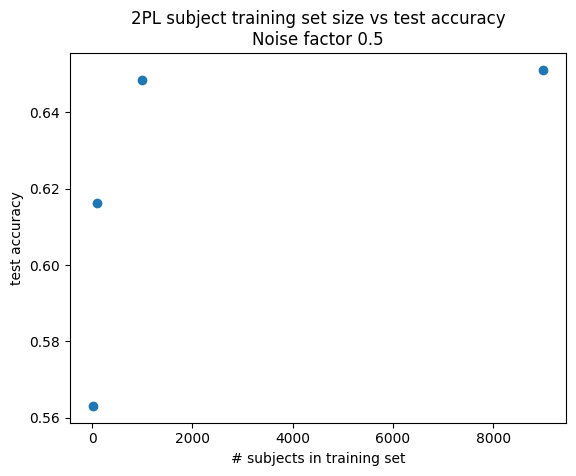

In [195]:
import matplotlib.pyplot as plt
#fig =plt.subplots()
plt.scatter(x=accuracies_dic.keys(),y=accuracies_dic.values())
plt.title("2PL subject training set size vs test accuracy\nNoise factor 0.5")
plt.xlabel("# subjects in training set")
plt.ylabel("test accuracy")

In [196]:
#need to generate sets of items with say, discrimination 
discs = np.arange(0,2,0.25)
discs

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75])

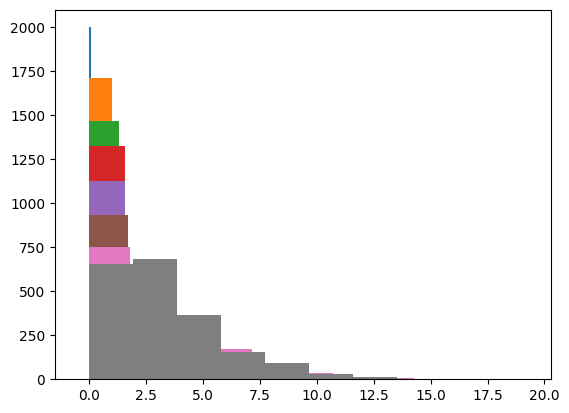

In [200]:
for disc in discs:
    plt.hist(np.random.gamma(size=N_ITEMS, shape=disc, scale=2))
